# Credit Card Fraud Detection Project

## Import Necessary Libraries

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

## Load and Merge Data

In [4]:
cc_info = pd.read_csv('cc_info.csv')
transactions = pd.read_csv('transactions.csv')

In [6]:
# Merge on 'credit_card'
merged_df = transactions.merge(cc_info, on='credit_card', how='left')

# Convert 'date' to datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

merged_df.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000


In [52]:
merged_df.shape

(294588, 23)

### Look for null/missing values

In [9]:
merged_df.isnull().sum()

credit_card                  0
date                         0
transaction_dollar_amount    0
Long                         0
Lat                          0
city                         0
state                        0
zipcode                      0
credit_card_limit            0
dtype: int64

### Visualize numerical data

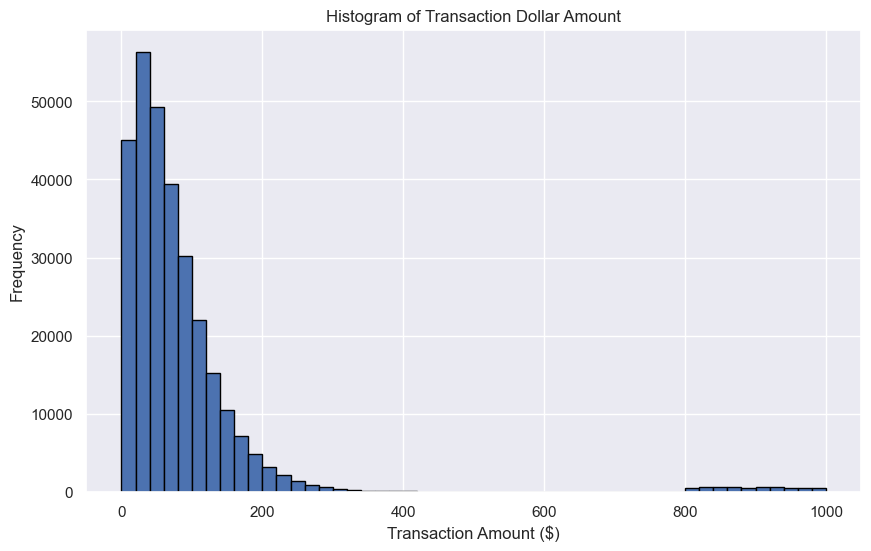

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(merged_df['transaction_dollar_amount'], bins=50, edgecolor='black')
plt.title('Histogram of Transaction Dollar Amount')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Frequency')
plt.show()

We can see that most transactions fall below \$500, however it looks like there are a few transactions between \$800 and \$1,000. These are most likely fraud transactions that we will look to classify.

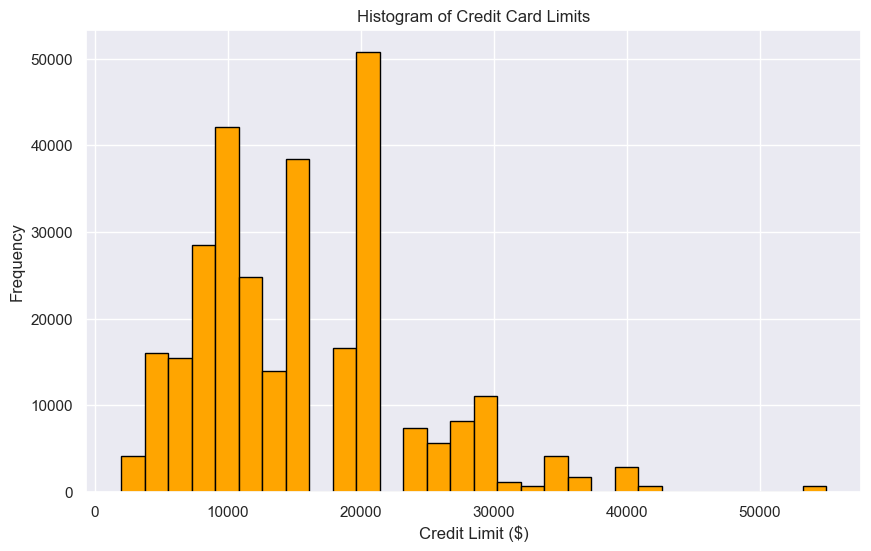

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(merged_df['credit_card_limit'], bins=30, edgecolor='black', color='orange')
plt.title('Histogram of Credit Card Limits')
plt.xlabel('Credit Limit ($)')
plt.ylabel('Frequency')
plt.show()

Now that we have all of the pertinent information on one data frame and see that we don't have any missing values, we will continue with feature engineering.

## Feature Engineering

My goals for feature engineering are to create the following variables:

Amount Limit Ration: calculates the ratio of the transaction amount to the credit limit.

Transaction Hour: extracts the hour from the transaction timestamp.

Transaction Count per Card: the total number of transactions on each card.

Daily Total Amount: the daily total number of transactions on each card.

Amount Zscore: shows how extreme each transaction is compared with the card's normal behavior

In [17]:
# Transaction Amount to Credit Limit Ratio
merged_df['amount_limit_ratio'] = merged_df['transaction_dollar_amount'] / merged_df['credit_card_limit']

# Transaction Hour
merged_df['transaction_hour'] = merged_df['date'].dt.hour

# Transaction Count per Card
merged_df['transaction_count_per_card'] = merged_df.groupby('credit_card')['credit_card'].transform('count')

# Daily Total Amount per Card
merged_df['transaction_date'] = merged_df['date'].dt.date
merged_df['daily_total_amount'] = merged_df.groupby(['credit_card', 'transaction_date'])['transaction_dollar_amount'].transform('sum')

# Z-score of transaction amount per card
merged_df['amount_mean'] = merged_df.groupby('credit_card')['transaction_dollar_amount'].transform('mean')
merged_df['amount_std'] = merged_df.groupby('credit_card')['transaction_dollar_amount'].transform('std')
merged_df['amount_zscore'] = (merged_df['transaction_dollar_amount'] - merged_df['amount_mean']) / merged_df['amount_std']

In [19]:
merged_df.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,amount_limit_ratio,transaction_hour,transaction_count_per_card,transaction_date,daily_total_amount,amount_mean,amount_std,amount_zscore
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000,0.002189,0,261,2015-09-11,1411.40,110.497471,129.120961,-0.516705
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000,0.005158,22,261,2015-10-24,457.24,110.497471,129.120961,-0.056904
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000,0.002427,18,261,2015-10-26,174.04,110.497471,129.120961,-0.479763
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000,0.006809,19,261,2015-10-22,310.08,110.497471,129.120961,0.198903
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000,0.003591,20,261,2015-10-26,174.04,110.497471,129.120961,-0.299544


## Model Building

We will use 4 different unsupervised algorithms and compare which one performs the best; KMeans Clustering, Density-Based Anomaly Detection (DBSCAN), Local Outlier Factor (LOF), and Isolation Forest.

### KMeans Clustering

In [41]:
features = merged_df[['amount_limit_ratio', 'transaction_hour', 'transaction_count_per_card',
                      'daily_total_amount', 'amount_zscore']].fillna(0)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
merged_df['kmeans_cluster'] = kmeans.fit_predict(scaled_features)

# Calculate distance to cluster center as an anomaly score
merged_df['kmeans_distance'] = np.linalg.norm(scaled_features - kmeans.cluster_centers_[merged_df['kmeans_cluster']], axis=1)

# Cluster summary
print(merged_df['kmeans_cluster'].value_counts())
print(merged_df[['kmeans_cluster', 'kmeans_distance']].describe())

kmeans_cluster
1    242688
0     46374
2      5526
Name: count, dtype: int64
       kmeans_cluster  kmeans_distance
count   294588.000000    294588.000000
mean         0.861339         1.403724
std          0.396171         0.847232
min          0.000000         0.065984
25%          1.000000         0.911995
50%          1.000000         1.234439
75%          1.000000         1.673020
max          2.000000        32.184705


### DBSCAN

One issue I ran into while running the DBSCAN algorithm on the full dataset was that it overloaded my RAM due to the sheer size of the dataset. To overcome this issue, I randomly sampled 10,000 observations from the original dataset.

In [30]:
# Sample 10,000 rows for DBSCAN
sample_df = merged_df.sample(n=10000, random_state=42)
sample_features = sample_df[['amount_limit_ratio', 'transaction_hour', 'transaction_count_per_card',
                             'daily_total_amount', 'amount_zscore']].fillna(0)

scaler = StandardScaler()
sample_scaled = scaler.fit_transform(sample_features)

dbscan = DBSCAN(eps=1.5, min_samples=10)
sample_df['dbscan_label'] = dbscan.fit_predict(sample_scaled)

print(sample_df['dbscan_label'].value_counts())

dbscan_label
 0    9812
 1     129
-1      59
Name: count, dtype: int64


### LOF

In [36]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
merged_df['lof_score'] = lof.fit_predict(scaled_features)
merged_df['lof_outlier_score'] = lof.negative_outlier_factor_

lof_outliers = (merged_df['lof_score'] == -1).sum()
print(f"LOF flagged {lof_outliers} outliers.")

LOF flagged 2946 outliers.


### Isolation Forest

In [43]:
isoforest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
merged_df['isoforest_score'] = isoforest.fit_predict(scaled_features)
merged_df['isoforest_anomaly_score'] = isoforest.decision_function(scaled_features)

iso_outliers = (merged_df['isoforest_score'] == -1).sum()
print(f"Isolation Forest flagged {iso_outliers} outliers.")

Isolation Forest flagged 2946 outliers.


## Results

In [50]:
smallest_cluster_id = merged_df['kmeans_cluster'].value_counts().idxmin()
comparison_summary = pd.DataFrame({
    'Method': ['KMeans', 'DBSCAN', 'LOF', 'Isolation Forest'],
    'Num Outliers': [
        len(merged_df[merged_df['kmeans_cluster'] == smallest_cluster_id]),  # define this
        (sample_df['dbscan_label'] == -1).sum(),
        (merged_df['lof_score'] == -1).sum(),
        (merged_df['isoforest_score'] == -1).sum()
    ]
})
print(comparison_summary)

             Method  Num Outliers
0            KMeans          5526
1            DBSCAN            59
2               LOF          2946
3  Isolation Forest          2946


LOF and isolation forest have both identified 2,946 outliers, which is about 1% of the total dataset. Even though DBSCAN was trained on a sample dataset, it still identified about 0.5% of the full dataset as outliers which is comparable to LOF and isolation forest. Since I was unable to train DBSCAN on the full dataset, I plan to eliminate that model from contention. KMeans classified almost double the amount of outliers as LOF and isolation forest, but is it really the better algorithm? I will determine that by looking at distributions of the anomaly scores.

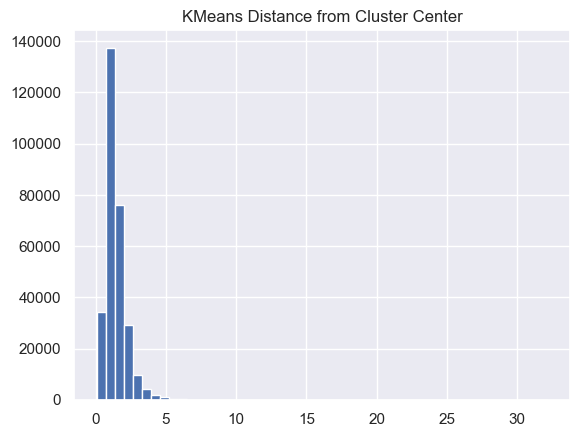

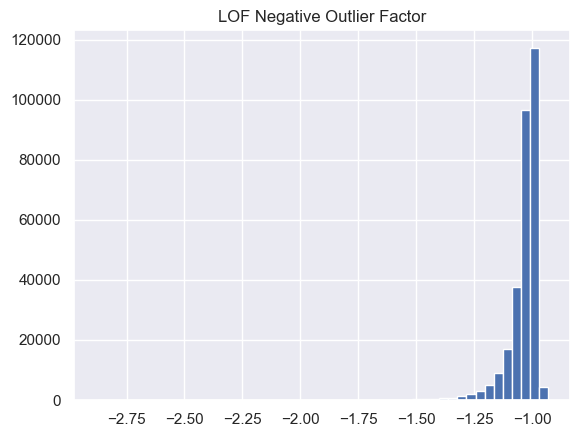

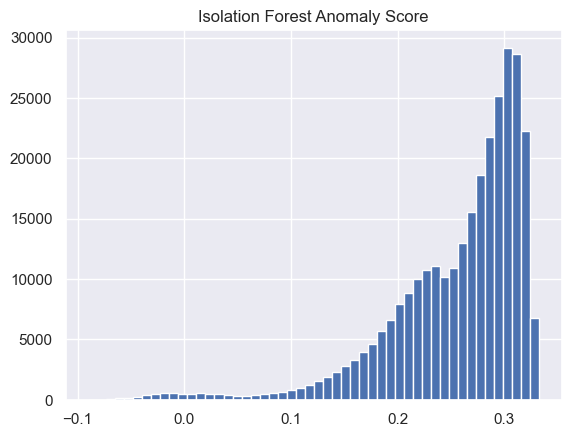

In [54]:
# Histogram of KMeans distance scores
plt.hist(merged_df['kmeans_distance'], bins=50)
plt.title('KMeans Distance from Cluster Center')
plt.show()

# Histogram of LOF outlier score
plt.hist(merged_df['lof_outlier_score'], bins=50)
plt.title('LOF Negative Outlier Factor')
plt.show()

# Histogram of Isolation Forest scores
plt.hist(merged_df['isoforest_anomaly_score'], bins=50)
plt.title('Isolation Forest Anomaly Score')
plt.show()

Typically, a good distribution of anomaly scores is shown by having a clear tail on the graph. Based off of this factor, I would say that the best model would be the isolation forest.

## Future Work

If I was to come back to this project, I would like to improve the DBSCAN algorithm using PCA so it can utilize the full dataset to determine if it could compare to isolation forest.